In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats import false_discovery_control
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE
pd.set_option('display.max_columns', None)

In [2]:
# Creating data frame,
# Finding mean of Normal, NET and NEC per cdID,
# Compute difference of means between Normal, NET and NEC

In [3]:
superdf = pd.read_csv('RawmethLabel.txt', sep="\t").set_index('ID_REF')

lung = superdf.loc[:, superdf.columns.str.contains('lung')]
lungNormal = lung.loc[:, lung.columns.str.contains('normal')]
lungNET = lung.loc[:, lung.columns.str.contains('NET.tumor')]
lungNEC = lung.loc[:, lung.columns.str.contains('NEC.tumor')]

lung['Normal Mean'] = lungNormal.mean(axis=1)
lung['NET Mean'] = lungNET.mean(axis=1)
lung['NEC Mean'] = lungNEC.mean(axis=1)

lung['NET - Normal'] = lung['NET Mean'] - lung['Normal Mean']
lung['NEC - NET'] = lung['NEC Mean'] - lung['NET Mean']
lung['NEC - Normal'] = lung['NEC Mean'] - lung['Normal Mean']

lung

,lung.NET.normal.lung.G2.dead,lung.NET.tumor.lung.G2.alive,lung.NET.tumor.lung.G1.dead,lung.NEC.normal.lung.G3.alive,lung.NEC.tumor.lung.G3.alive,lung.NET.tumor.lung.G1.alive,lung.NET.tumor.lung.G1.alive.1,lung.NEC.tumor.lung.G3.dead,lung.NET.tumor.lung.G2.dead,lung.NEC.tumor.lung.G3.dead.1,lung.NET.normal.lung.G1.alive,lung.NET.tumor.lung.G1.alive.2,lung.NET.tumor.lung.G1.alive.3,lung.NET.tumor.lung.G1.alive.4,lung.NEC.tumor.lung.G3.dead.2,lung.NET.normal.lung.G1.alive.1,lung.NET.tumor.lung.G1.alive.5,lung.NET.normal.lung.G2.alive,lung.NET.tumor.lung.G2.alive.1,lung.NEC.normal.lung.G3.dead,lung.NET.tumor.lung.G3.dead,lung.NET.tumor.lung.G1.alive.6,lung.NEC.normal.lung.G3.dead.1,lung.NEC.tumor.lung.G3.dead.3,lung.NEC.tumor.lung.G3.dead.4,lung.NET.tumor.lung.G1.dead.1,lung.NET.tumor.lung.G1.alive.7,lung.NEC.tumor.lung.G3.dead.5,lung.NET.tumor.lung.G1.dead.2,lung.NET.tumor.lung.G1.alive.8,lung.NEC.tumor.lung.G3.alive.1,lung.NET.normal.lung.G1.alive.2,lung.NET.tumor.lung.G1.alive.9,Normal Mean,NET Mean,NEC Mean,NET - Normal,NEC - NET,NEC - Normal
ID_REF,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cg18478105,0.107536,0.063771,0.069309,0.079572,0.084122,0.129928,0.100341,0.064497,0.120076,0.099264,0.061066,0.065821,0.110670,0.071083,0.110226,0.078992,0.042394,0.210592,0.178800,0.144027,0.169399,0.083562,0.050477,0.078513,0.079966,0.059977,0.088953,0.067026,0.070677,0.070390,0.067752,0.056130,0.101220,0.098549,0.093904,0.081421,-0.004645,-0.012483,-0.017128
cg09835024,0.313253,0.047141,0.070931,0.136567,0.083475,0.176916,0.070922,0.089723,0.091551,0.067458,0.059231,0.052387,0.119746,0.042069,0.151747,0.034344,0.015056,0.137892,0.086030,0.153575,0.270231,0.055573,0.133101,0.076121,0.057527,0.041400,0.045184,0.041644,0.065169,0.052097,0.047021,0.062768,0.216895,0.128841,0.089371,0.076839,-0.039471,-0.012531,-0.052002
cg14361672,0.636765,0.658975,0.366406,0.418898,0.599976,0.602186,0.754625,0.771442,0.220434,0.734672,0.351735,0.627378,0.583350,0.602014,0.709174,0.206961,0.452937,0.635522,0.550327,0.585581,0.281222,0.696032,0.360691,0.657307,0.395496,0.374935,0.556159,0.598185,0.616874,0.688944,0.500433,0.502319,0.273844,0.462309,0.523920,0.620836,0.061611,0.096916,0.158527
cg01763666,0.544365,0.460922,0.596109,0.550575,0.520245,0.588508,0.334176,0.625146,0.558414,0.258439,0.582472,0.615242,0.497392,0.676557,0.215975,0.406194,0.637817,0.545940,0.429647,0.563713,0.477050,0.680681,0.463142,0.669194,0.771729,0.398827,0.669374,0.570159,0.672635,0.324039,0.670058,0.653968,0.190834,0.538796,0.518131,0.537618,-0.020665,0.019487,-0.001178
cg12950382,0.812081,0.848817,0.806746,0.841164,0.859025,0.787089,0.869172,0.799802,0.715328,0.857484,0.742982,0.641975,0.855109,0.882311,0.904894,0.862416,0.889525,0.840015,0.783165,0.876123,0.600848,0.882734,0.896331,0.868784,0.878682,0.792660,0.778267,0.864973,0.892391,0.878724,0.905353,0.891099,0.845639,0.845276,0.808853,0.867375,-0.036423,0.058522,0.022098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg23079522,0.718157,0.862670,0.854807,0.783633,0.823081,0.845266,0.698611,0.863136,0.729878,0.805914,0.819967,0.898674,0.823398,0.839486,0.850880,0.782561,0.743458,0.835657,0.786135,0.688518,0.742731,0.760365,0.647059,0.719433,0.801493,0.850500,0.750760,0.825458,0.763898,0.886137,0.887654,0.636307,0.835938,0.738982,0.804277,0.822131,0.065295,0.017854,0.083149
cg16818145,0.619613,0.717207,0.769765,0.667985,0.772434,0.680349,0.770931,0.678559,0.706949,0.664402,0.724033,0.736681,0.731046,0.786025,0.700944,0.597908,0.800403,0.643087,0.587689,0.677169,0.299117,0.674810,0.697500,0.735677,0.746037,0.634658,0.583832,0.726889,0.663395,0.771128,0.660039,0.672831,0.651734,0.662516,0.680336,0.710623,0.017821,0.030286,0.048107
cg14585103,0.493976,0.092042,0.162705,0.628490,0.284619,0.487944,0.653520,0.378855,0.258225,0.137675,0.161234,0.516644,0.570193,0.638603,0.087439,0.058511,0.701466,0.453887,0.336500,0.638155,

In [4]:
#KS test that takes in two samples eg. NET and Normal

In [5]:
def ks_test(sample1, sample2):
    results = []

    for cgid in sample1.index:
        sample1VALUE = sample1.loc[cgid].values
        sample2VALUE = sample2.loc[cgid].values

        stat, pvalue = ks_2samp(sample1VALUE, sample2VALUE)
        results.append({'ID_REF': cgid, 'Pvalue': pvalue})

    
    output = pd.DataFrame(results).set_index('ID_REF')

    return output 

In [7]:
lungKSnetnormal = ks_test(lungNET, lungNormal)

lungKSnecnet = ks_test(lungNEC, lungNET)

lungKSnecnormal = ks_test(lungNEC, lungNormal)

In [9]:
#FDR test

In [10]:
FDRnetnormal = false_discovery_control(lungKSnetnormal['Pvalue'], method='bh')
lungKSnetnormal = lungKSnetnormal.rename(columns={'Pvalue': 'NET - Normal Pvalue'})
lungKSnetnormal['NET - Normal FDR'] = FDRnetnormal

FDRnecnet = false_discovery_control(lungKSnecnet['Pvalue'], method='bh')
lungKSnecnet = lungKSnecnet.rename(columns={'Pvalue': 'NEC - NET Pvalue'})
lungKSnecnet['NEC - NET FDR'] = FDRnecnet

FDRnecnormal = false_discovery_control(lungKSnecnormal['Pvalue'], method='bh')
lungKSnecnormal = lungKSnecnormal.rename(columns={'Pvalue': 'NEC - Normal Pvalue'})
lungKSnecnormal['NEC - Normal FDR'] = FDRnecnormal

In [11]:
lung = pd.concat([
    lung,
    lungKSnetnormal[['NET - Normal Pvalue']],
    lungKSnecnet[['NEC - NET Pvalue']],
    lungKSnecnormal[['NEC - Normal Pvalue']],
    lungKSnetnormal[['NET - Normal FDR']],
    lungKSnecnet[['NEC - NET FDR']],
    lungKSnecnormal[['NEC - Normal FDR']]
], axis=1, join='outer')

lung 

,lung.NET.normal.lung.G2.dead,lung.NET.tumor.lung.G2.alive,lung.NET.tumor.lung.G1.dead,lung.NEC.normal.lung.G3.alive,lung.NEC.tumor.lung.G3.alive,lung.NET.tumor.lung.G1.alive,lung.NET.tumor.lung.G1.alive.1,lung.NEC.tumor.lung.G3.dead,lung.NET.tumor.lung.G2.dead,lung.NEC.tumor.lung.G3.dead.1,lung.NET.normal.lung.G1.alive,lung.NET.tumor.lung.G1.alive.2,lung.NET.tumor.lung.G1.alive.3,lung.NET.tumor.lung.G1.alive.4,lung.NEC.tumor.lung.G3.dead.2,lung.NET.normal.lung.G1.alive.1,lung.NET.tumor.lung.G1.alive.5,lung.NET.normal.lung.G2.alive,lung.NET.tumor.lung.G2.alive.1,lung.NEC.normal.lung.G3.dead,lung.NET.tumor.lung.G3.dead,lung.NET.tumor.lung.G1.alive.6,lung.NEC.normal.lung.G3.dead.1,lung.NEC.tumor.lung.G3.dead.3,lung.NEC.tumor.lung.G3.dead.4,lung.NET.tumor.lung.G1.dead.1,lung.NET.tumor.lung.G1.alive.7,lung.NEC.tumor.lung.G3.dead.5,lung.NET.tumor.lung.G1.dead.2,lung.NET.tumor.lung.G1.alive.8,lung.NEC.tumor.lung.G3.alive.1,lung.NET.normal.lung.G1.alive.2,lung.NET.tumor.lung.G1.alive.9,Normal Mean,NET Mean,NEC Mean,NET - Normal,NEC - NET,NEC - Normal,NET - Normal Pvalue,NEC - NET Pvalue,NEC - Normal Pvalue,NET - Normal FDR,NEC - NET FDR,NEC - Normal FDR
ID_REF,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cg18478105,0.107536,0.063771,0.069309,0.079572,0.084122,0.129928,0.100341,0.064497,0.120076,0.099264,0.061066,0.065821,0.110670,0.071083,0.110226,0.078992,0.042394,0.210592,0.178800,0.144027,0.169399,0.083562,0.050477,0.078513,0.079966,0.059977,0.088953,0.067026,0.070677,0.070390,0.067752,0.056130,0.101220,0.098549,0.093904,0.081421,-0.004645,-0.012483,-0.017128,0.779488,0.599747,0.660140,0.962489,0.869459,0.837076
cg09835024,0.313253,0.047141,0.070931,0.136567,0.083475,0.176916,0.070922,0.089723,0.091551,0.067458,0.059231,0.052387,0.119746,0.042069,0.151747,0.034344,0.015056,0.137892,0.086030,0.153575,0.270231,0.055573,0.133101,0.076121,0.057527,0.041400,0.045184,0.041644,0.065169,0.052097,0.047021,0.062768,0.216895,0.128841,0.089371,0.076839,-0.039471,-0.012531,-0.052002,0.176859,0.891089,0.282673,0.790075,0.963219,0.583850
cg14361672,0.636765,0.658975,0.366406,0.418898,0.599976,0.602186,0.754625,0.771442,0.220434,0.734672,0.351735,0.627378,0.583350,0.602014,0.709174,0.206961,0.452937,0.635522,0.550327,0.585581,0.281222,0.696032,0.360691,0.657307,0.395496,0.374935,0.556159,0.598185,0.616874,0.688944,0.500433,0.502319,0.273844,0.462309,0.523920,0.620836,0.061611,0.096916,0.158527,0.712907,0.556257,0.282673,0.940491,0.869459,0.583850
cg01763666,0.544365,0.460922,0.596109,0.550575,0.520245,0.588508,0.334176,0.625146,0.558414,0.258439,0.582472,0.615242,0.497392,0.676557,0.215975,0.406194,0.637817,0.545940,0.429647,0.563713,0.477050,0.680681,0.463142,0.669194,0.771729,0.398827,0.669374,0.570159,0.672635,0.324039,0.670058,0.653968,0.190834,0.538796,0.518131,0.537618,-0.020665,0.019487,-0.001178,0.420032,0.891089,0.660140,0.864260,0.963219,0.837076
cg12950382,0.812081,0.848817,0.806746,0.841164,0.859025,0.787089,0.869172,0.799802,0.715328,0.857484,0.742982,0.641975,0.855109,0.882311,0.904894,0.862416,0.889525,0.840015,0.783165,0.876123,0.600848,0.882734,0.896331,0.868784,0.878682,0.792660,0.778267,0.864973,0.892391,0.878724,0.905353,0.891099,0.845639,0.845276,0.808853,0.867375,-0.036423,0.058522,0.022098,0.420032,0.067368,0.660140,0.864260,0.543180,0.837076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg23079522,0.718157,0.862670,0.854807,0.783633,0.823081,0.845266,0.698611,0.863136,0.729878,0.805914,0.819967,0.898674,0.823398,0.839486,0.850880,0.782561,0.743458,0.835657,0.786135,0.688518,0.742731,0.760365,0.647059,0.719433,0.801493,0.850500,0.750760,0.825458,0.763898,0.886137,0.887654,0.636307,0.835938,0.738982,0.804277,0.822131,0.065295,0.017854,0.083149,0.113647,0.420032,0.087024,0.732899,0.789970,0.358607
cg16818145,0.619613,0.717207,0.769765,0.667985,0.772434,0.680349,0.770931,0.678559,0.706949,0.

In [12]:
# Color Chart 
# Normal Cell: green (#008000) lightgreen
# Tumor Cell: red (#FF0000)
# Lung: pink (#FFC0CB)
# Gastropancreatic: orange (#FFA500)
# Alive: lightblue (#ADD8E6)
# Dead: purple (#800080)
# NET: #DA70D6 (hotpink) #FF66FF
# NEC: #483D8B (Dark Slate Blue) #CC00CC

In [13]:
# Boxplot of NET - Normal, NEC - NET and NEC - Normal

In [14]:
def boxplot(df, column, group_df=None, top_n=5, bottom_n=5, ylim=(0, 1.01), colors=None, title=None):
    if group_df is None:
        group_df = df
        
    if title is None:
        title = f'{column}'
    
    if colors is None:
        colors=["lightgreen", "#FF66FF", "#CC00CC"]  # Normal, NET, NEC

    # Get the top and bottom CGs
    sorted_df = df.sort_values(by=column, ascending=False)
    top_cgs = sorted_df.index[:top_n].tolist()
    bottom_cgs = sorted_df.index[-bottom_n:][::-1].tolist()

    def classify_sample(sample_name):
        s = sample_name.lower()
        if '.normal.' in s:
            return 'Normal'
        elif '.net.' in s:
            return 'NET'
        elif '.nec.' in s:
            return 'NEC'
        return None

    def get_sample_groups(cg):
        sample_groups = {'Normal': [], 'NET': [], 'NEC': []}
        for sample in group_df.columns:
            group = classify_sample(sample)
            if group:
                value = group_df.at[cg, sample]
                sample_groups[group].append(value)
        return sample_groups

    def cg_details(cg, column):
        row = df.loc[cg]
        sample_counts = {'Normal': 0, 'NET': 0, 'NEC': 0}

        for sample in group_df.columns:
            group = classify_sample(sample)
            if group:
                sample_counts[group] += 1

        total = sum(sample_counts.values())
        lines = []

        diff = row.get(column, np.nan)
        pval = row.get(f'{column} Pvalue', np.nan)
        fdr = row.get(f'{column} FDR', np.nan)
        stat_line = f"Difference = {diff:.2f}, Pvalue = {pval:.3g}, FDR = {fdr:.3g}"
        lines.append(stat_line)

        return '\n'.join(lines)

    def plot_cg(cg, rank, position=None):
        sample_groups = get_sample_groups(cg)
        data = [sample_groups['Normal'], sample_groups['NET'], sample_groups['NEC']]
        labels = ['Normal (N = 8)', 'NET (N = 17)', 'NEC (N = 8)']
        means = [np.mean(g) if g else 0 for g in data]

        plt.figure(figsize=(6, 4))
        box = plt.boxplot(data, patch_artist=True, labels=labels)

        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)

        mean_labels = ['Normal Mean', 'NET Mean', 'NEC Mean']
        for i, label in enumerate(mean_labels, start=1):
            mean_val = df.at[cg, label]
            plt.text(i + 0.2, mean_val, f'{mean_val:.3f}', ha='left', va='center', fontsize=9)



        # Annotation text below title
        annotation_text = cg_details(cg, column)
        plt.title(f'{title}\n{position} {rank}: {cg}')
        plt.suptitle(annotation_text, fontsize=9, y=0.02)
        plt.ylim(ylim)
        plt.ylabel('Methylation Ratio')
        plt.show()

    # Top loop
    print("\nTop CGs:")
    for rank, cg in enumerate(top_cgs, start=1):
        plot_cg(cg, rank, position='Hypermethylation Biomarker')
    # Bottom Loop
    print("\nBottom CGs:")
    for rank, cg in enumerate(bottom_cgs, start=1):
        plot_cg(cg, rank, position='Hypomethylation Biomarker')



Top CGs:


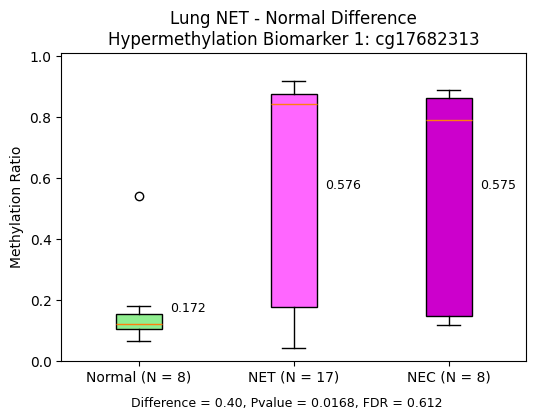

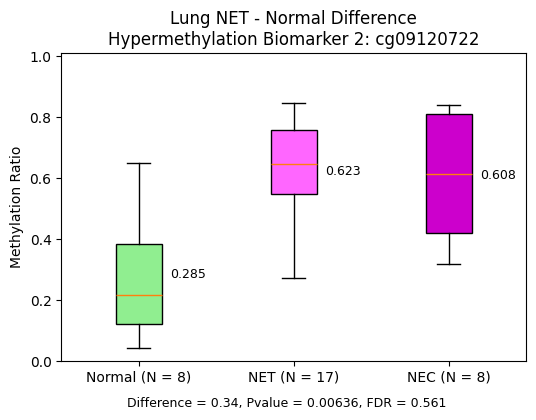

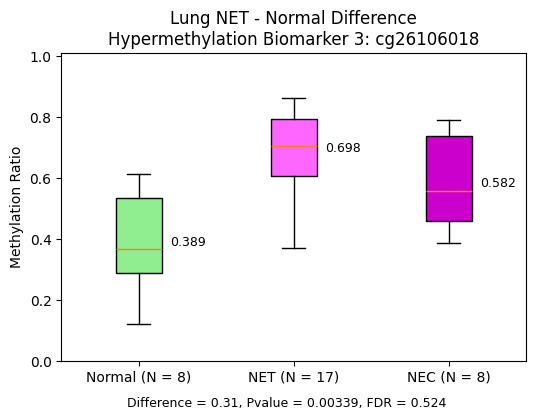

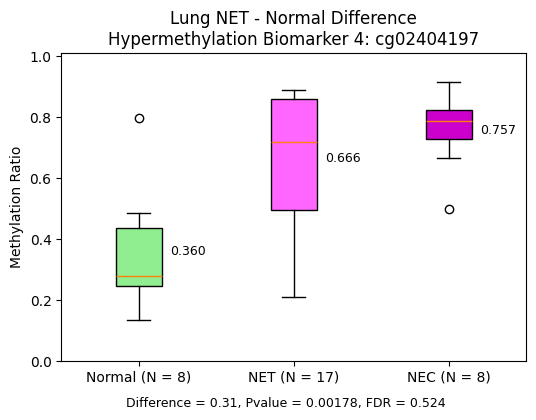

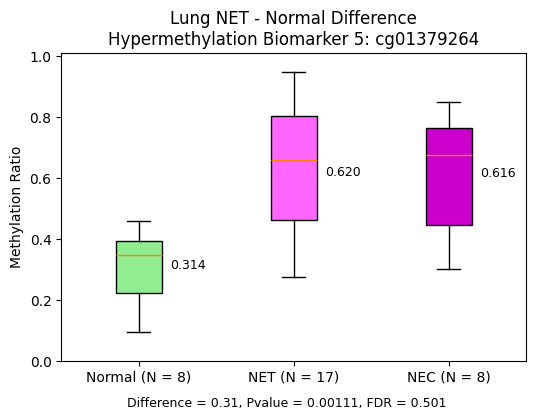


Bottom CGs:


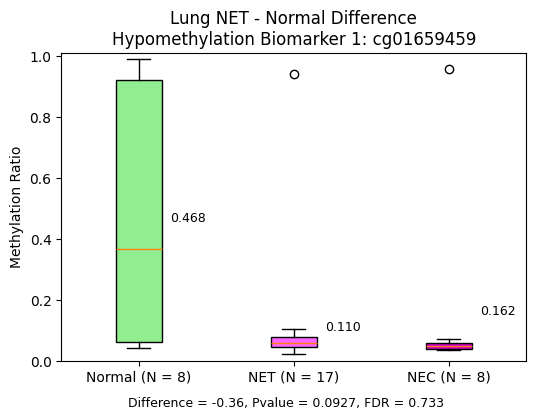

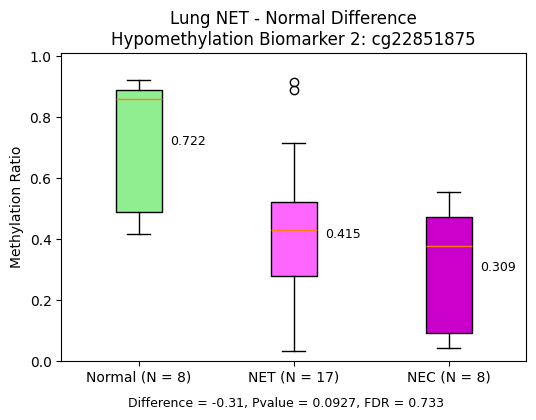

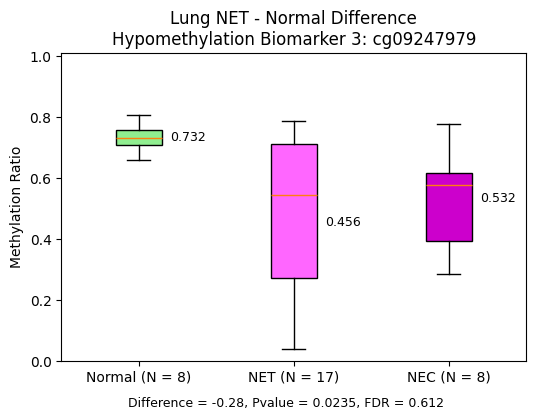

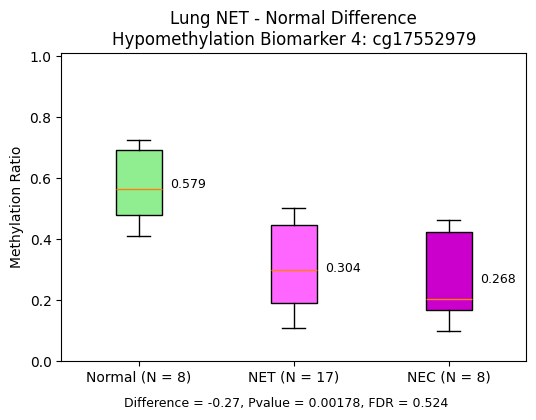

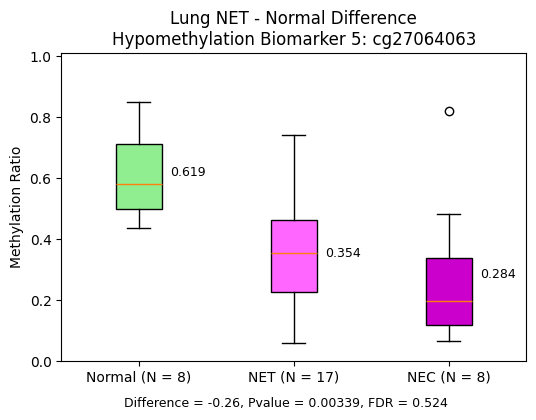


Top CGs:


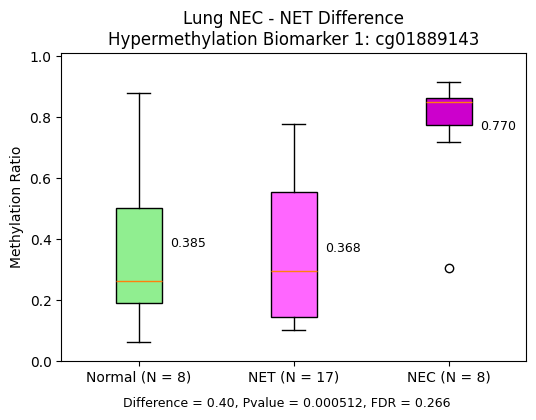

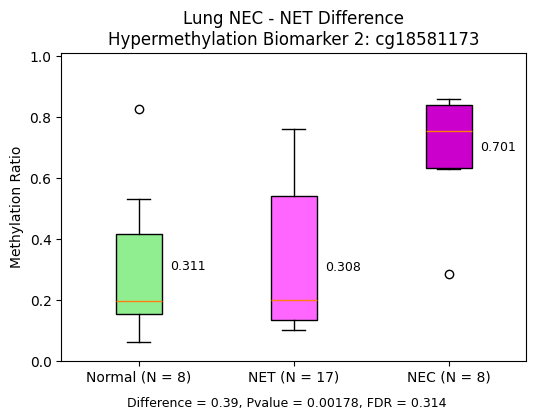

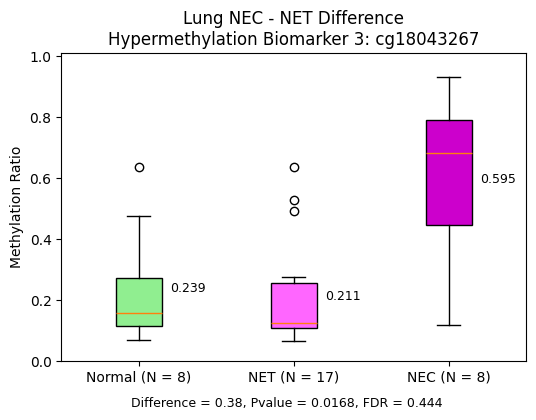

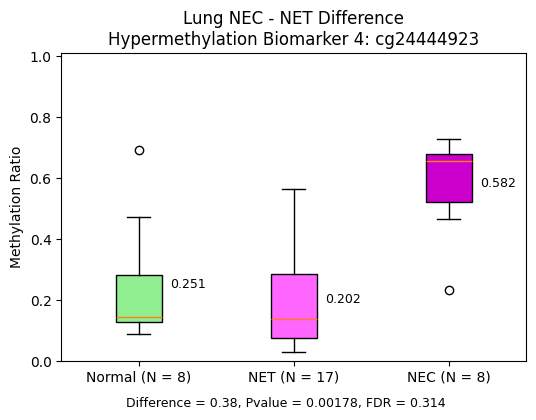

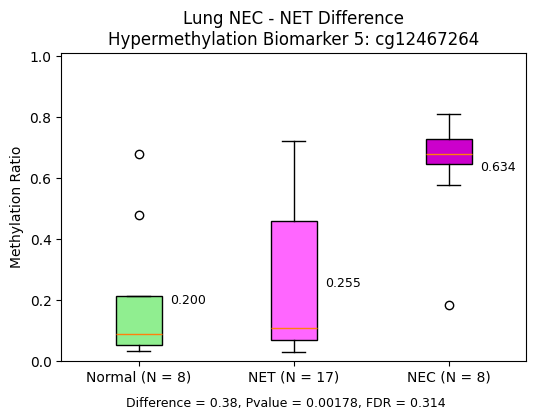


Bottom CGs:


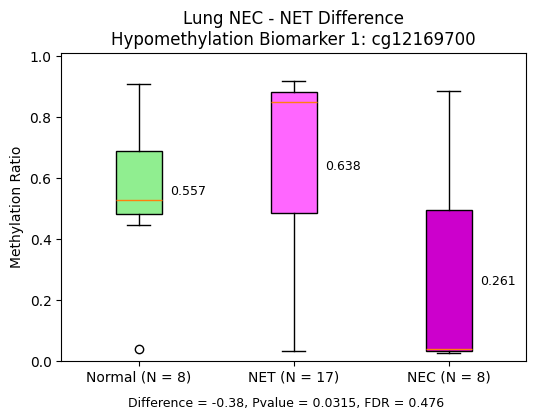

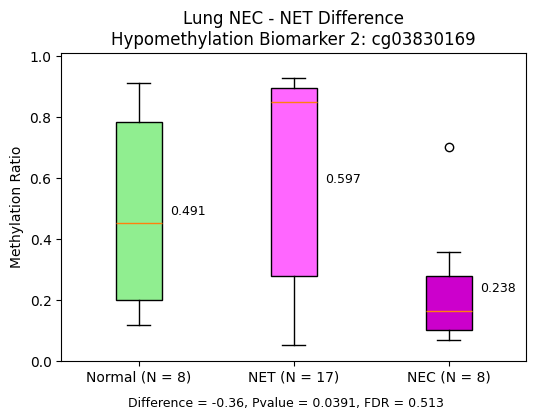

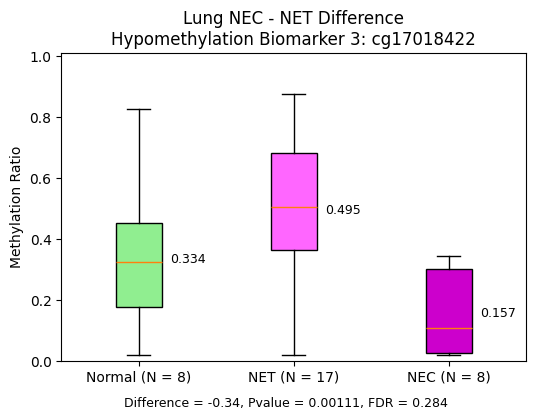

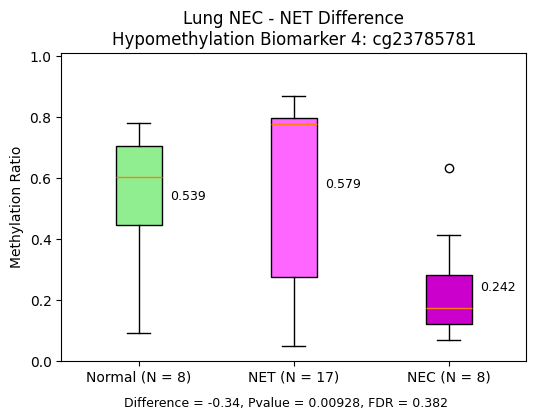

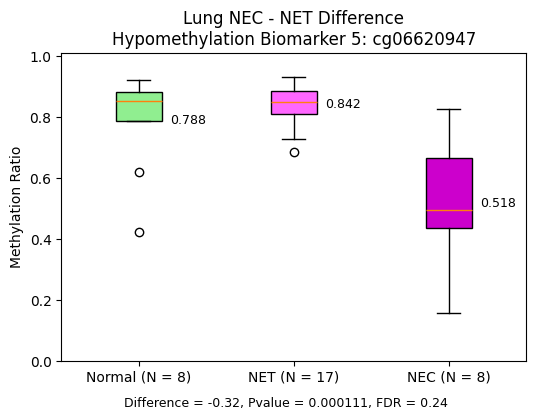


Top CGs:


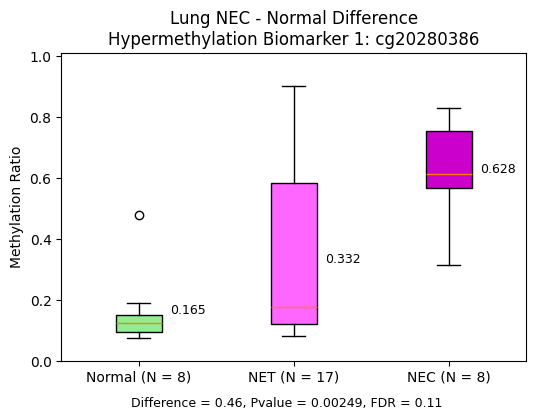

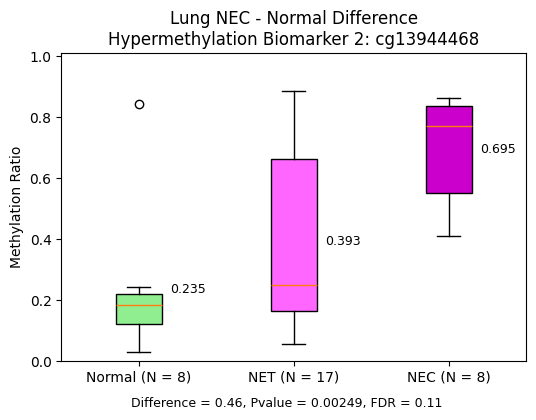

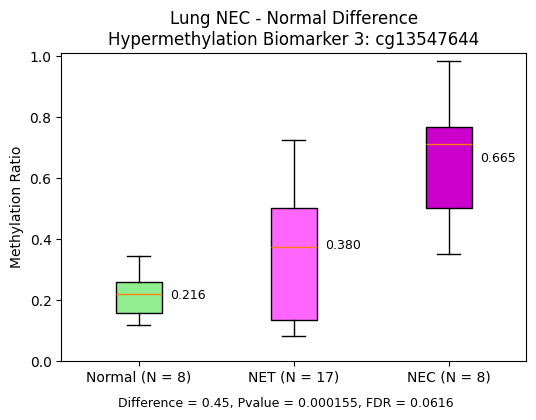

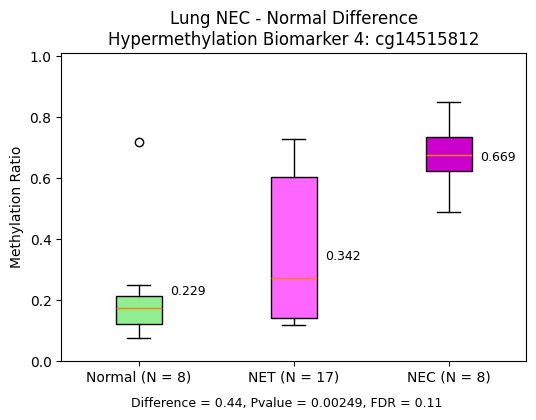

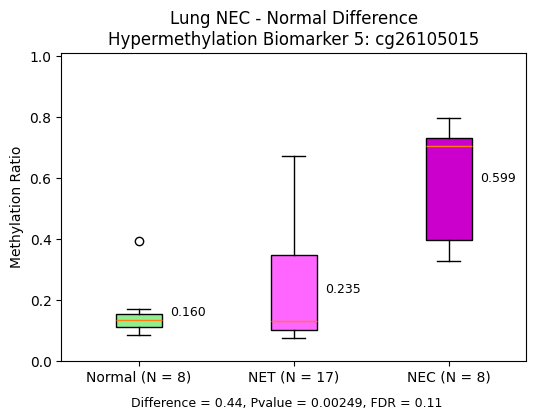


Bottom CGs:


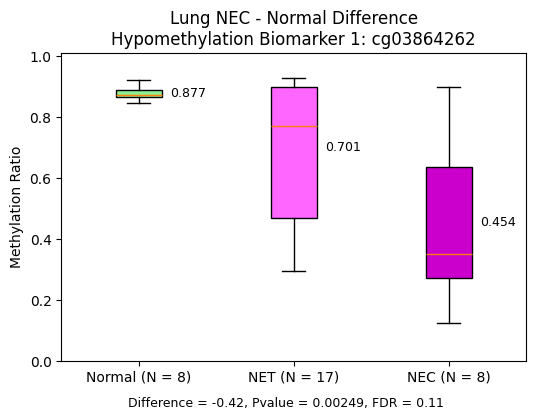

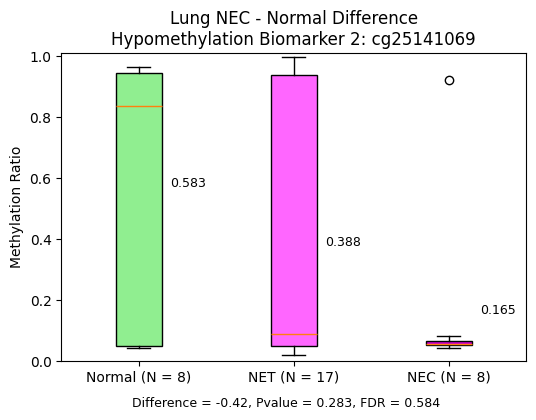

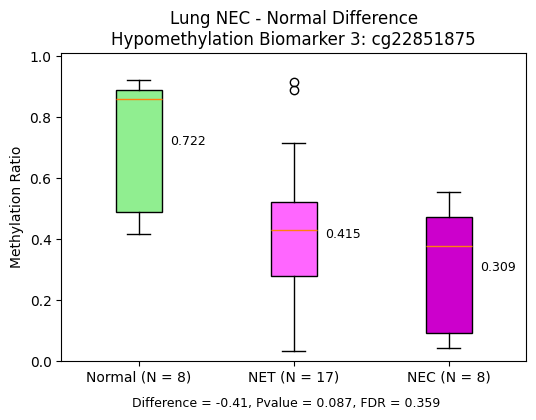

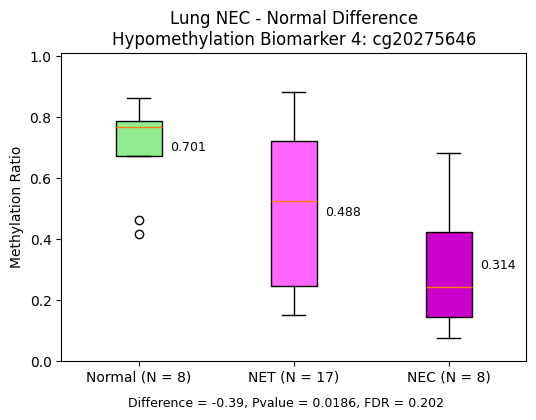

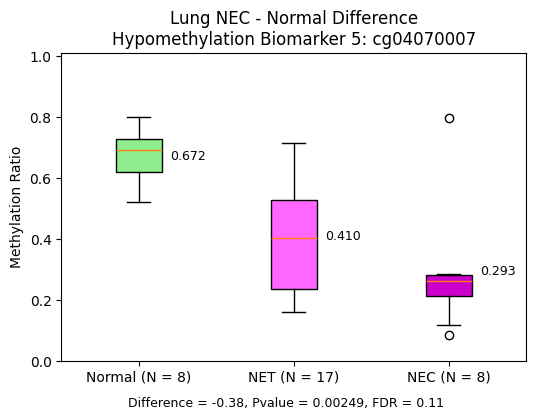

In [15]:
boxplot(
    df=lung,                          
    column='NET - Normal',            
    title='Lung NET - Normal Difference'
)

boxplot(
    df=lung,                          
    column='NEC - NET',                
    title='Lung NEC - NET Difference'
)

boxplot(
    df=lung,                          
    column='NEC - Normal',             
    title='Lung NEC - Normal Difference'
)


In [16]:
# Reusable function to extract cell type from sample names and coloring scsheme 

def extract_features(sample):

    sample = sample.lower()
    celltype = "Lung Normal" if ".normal." in sample else "Lung NET" if ".net." in sample else "Lung NEC" if ".nec." in sample else "Unknown"

    return celltype

celltypes = superdf.T.index.to_series().apply(extract_features)

custom_palette = {
    'Lung Normal': 'lightgreen',
    'Lung NET': '#FF66FF',
    'Lung NEC': '#CC00CC'
}

In [17]:
#PCA

In [18]:
pca = PCA(n_components=2)
superdf_pca = pca.fit_transform(superdf.T)

pca_df = pd.DataFrame(superdf_pca, columns=['PCA1', 'PCA2'], index=superdf.T.index).assign(CellType=celltypes.values)

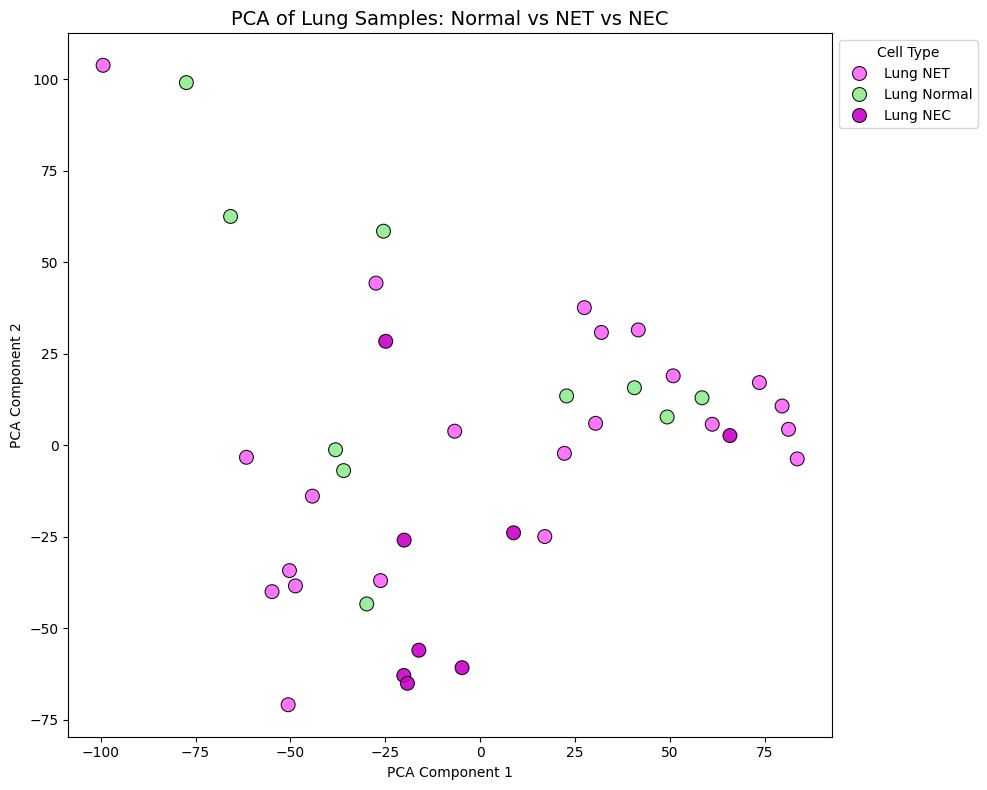

In [19]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pca_df,
    x='PCA1',
    y='PCA2',
    hue='CellType',
    palette=custom_palette,
    s=100,
    alpha=0.9,
    edgecolor='black'
)

plt.title('PCA of Lung Samples: Normal vs NET vs NEC', fontsize=14)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cell Type', bbox_to_anchor=(1.2, 1), loc='upper right')
plt.tight_layout()
plt.show()


In [20]:
#UMAP

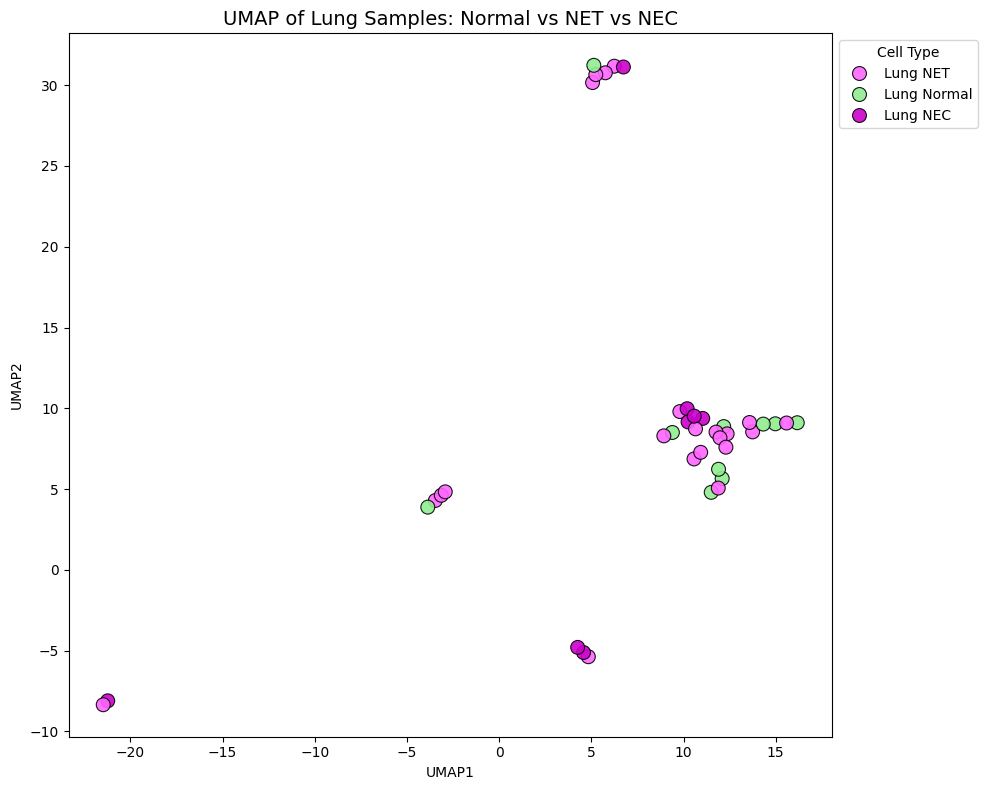

In [21]:
reducer = umap.UMAP(n_neighbors=2, min_dist=0.4, n_components=2)
embedding_umap = reducer.fit_transform(superdf.T)

umap_df = pd.DataFrame(embedding_umap, columns=['UMAP1', 'UMAP2'], index=superdf.T.index)
umap_df['CellType'] = celltypes.values

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=umap_df,
    x='UMAP1',
    y='UMAP2',
    hue='CellType',
    palette=custom_palette,
    s=100,
    alpha=0.9,
    edgecolor='black'
)
plt.title('UMAP of Lung Samples: Normal vs NET vs NEC', fontsize=14)
plt.legend(title='Cell Type', bbox_to_anchor=(1.2, 1), loc='upper right')
plt.tight_layout()
plt.show()


In [22]:
#TSNE

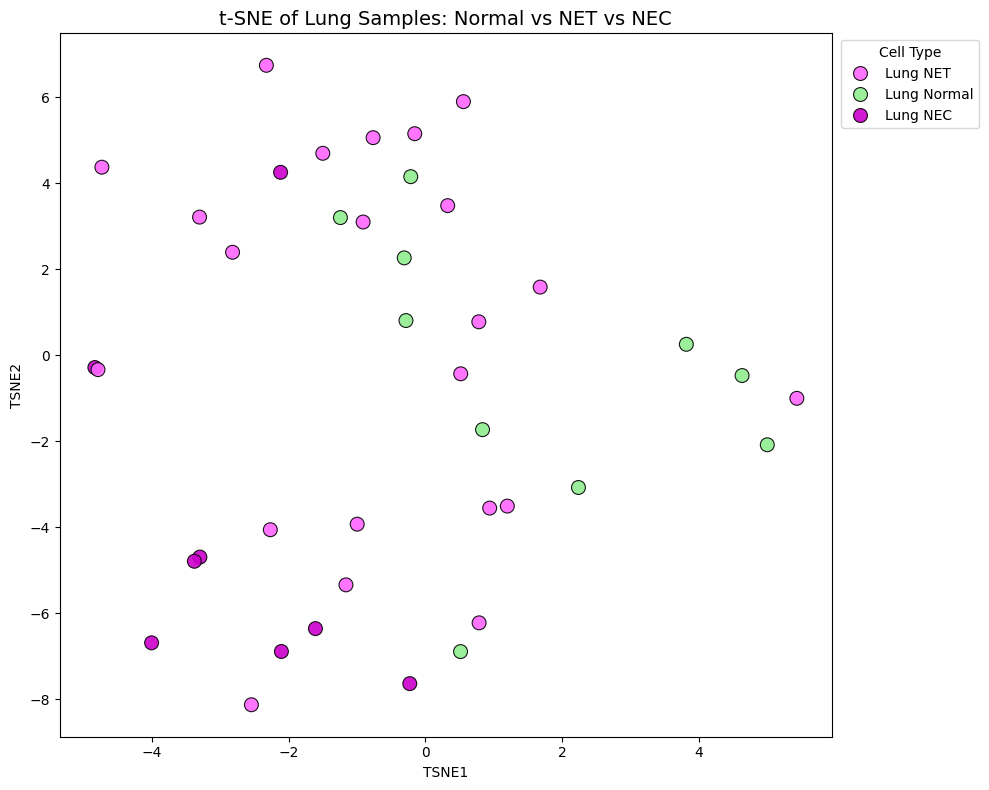

In [23]:
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
embedding_tsne = tsne.fit_transform(superdf.T)

tsne_df = pd.DataFrame(embedding_tsne, columns=['TSNE1', 'TSNE2'], index=superdf.T.index)
tsne_df['CellType'] = celltypes.values

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=tsne_df,
    x='TSNE1',
    y='TSNE2',
    hue='CellType',
    palette=custom_palette,
    s=100,
    alpha=0.9,
    edgecolor='black'
)
plt.title('t-SNE of Lung Samples: Normal vs NET vs NEC', fontsize=14)
plt.legend(title='Cell Type', bbox_to_anchor=(1.2, 1), loc='upper right')
plt.tight_layout()
plt.show()
